#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/opt/anaconda3/bin/python


# Install dependencies:

In [5]:
install_packages = True
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38h50d1736_0         3.1 MB  conda-forge
    openssl-1.1.1h             |       haf1e3a3_0         1.9 MB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    tbb-2019.9                 |       ha1b3eb9_1         157 KB  conda-forge
    umap-learn-0.4.6           |   py38h32f6830_0         111 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.2 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/osx-64::python_abi-3.8-1_cp38
  tbb                conda-forge/osx-64::tbb-2019.9-ha1b3eb9_1
  umap-learn         conda-forg

# Imports

In [6]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [7]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [5]:
# Set pandas print options
This will improve readability of printed pandas dataframe.


SyntaxError: invalid syntax (<ipython-input-5-804d46c41beb>, line 2)

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [9]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [10]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [11]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [12]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.41395524
n_clusters: 102 silhouette_avg: 0.3263698
n_clusters: 202 silhouette_avg: 0.31703973
n_clusters: 302 silhouette_avg: 0.30575132
n_clusters: 402 silhouette_avg: 0.30010957
n_clusters: 502 silhouette_avg: 0.29991764
n_clusters: 602 silhouette_avg: 0.29409203
n_clusters: 702 silhouette_avg: 0.29576808
n_clusters: 802 silhouette_avg: 0.2871438
n_clusters: 902 silhouette_avg: 0.28211346


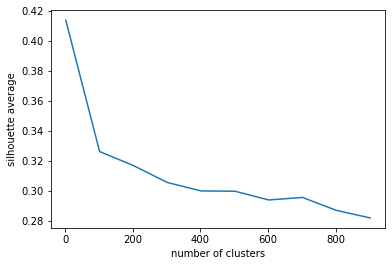

In [13]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [30]:
number_of_clusters =  600
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 590     1
94      1
559     1
262     1
519     1
229     1
542     1
71      1
571     1
128     1
126     1
43      1
254     1
224     1
318     1
313     1
340     1
485     1
217     1
500     1
92      1
114     1
558     1
298     1
514     1
142     1
31      1
177     1
598     1
583     1
138     1
33      1
574     1
293     1
179     1
277     1
278     1
80      1
140     1
555     1
442     1
512     1
398     1
595     1
216     1
351     1
581     1
573     1
565     1
548     1
549     1
403     1
423     1
284     1
353     1
357     1
528     1
311     1
312     1
361     1
588     1
596     1
386     1
399     1
368     1
586     1
373     1
406     1
441     1
553     1
437     1
484     1
389     1
401     1
327     1
416     1
464     1
425     1
421     1
336     1
508     1
429     1
326     2
236     2
342     2
158     2
150     2
194     2
130     2
156     2
535     2
527     2
238     2
515     2
66      2
507     2
54      2
481     2
551 

In [31]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [32]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

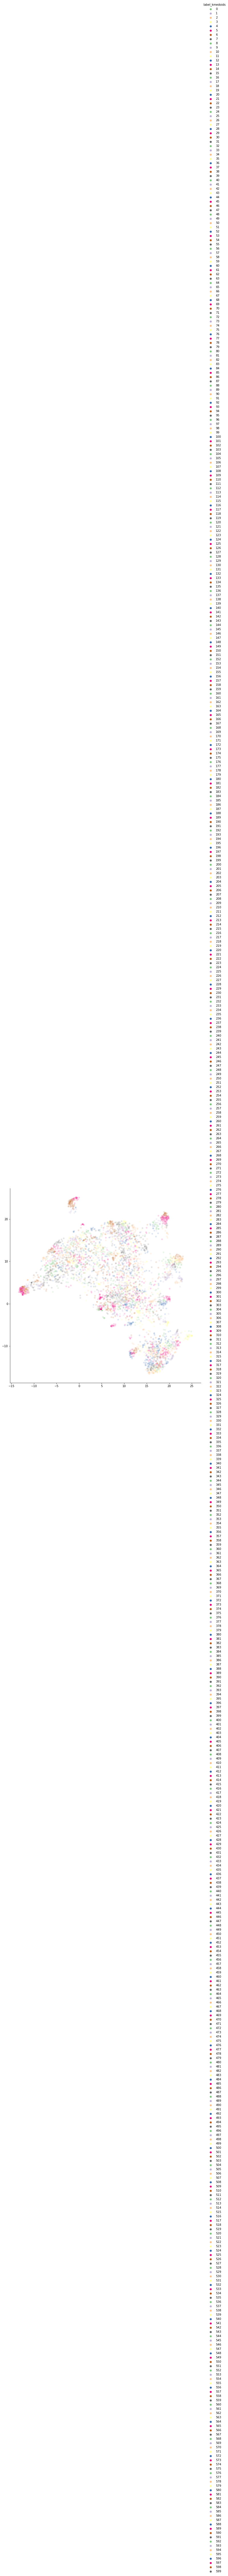

In [33]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

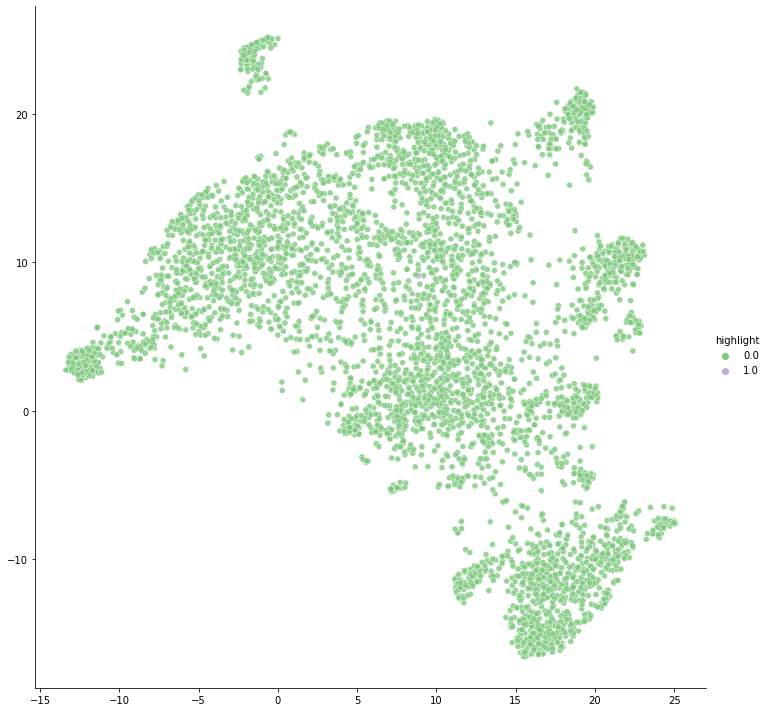

In [35]:
## Choose a cluster to higlight:
cluster_num = 0

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [36]:
# print the medoids 
data.iloc[medoids_indices]      

publishedAt                                       authorName  \
746   2020-10-01 15:44:00                                    Mortem’s Soul   
2619  2020-09-30 17:21:52                              Christian's Customs   
3981  2020-09-30 13:58:50                                            Fionn   
1457  2020-10-01 03:47:14               GG L o v e s g o r i l l a z & m j   
4289  2020-09-30 06:31:51                                          Ren Col   
3793  2020-10-04 15:19:53                                    Thomas Anholm   
199   2020-10-03 16:39:28                                       Jose Silva   
2111  2020-09-30 13:32:33                                            David   
2084  2020-09-30 12:55:58                                   Miguel Marania   
2491  2020-09-30 13:11:32                                         Shanchan   
4257  2020-09-30 09:26:05                                       JonnyBlack   
4229  2020-09-30 16:50:12                                         Jordan B   
3747  2020-09-30 09:45:01                                       Alec scott   
1350  2020-09-30 17:52:38                                       Devon hart   
1880  2020-09-30 17:07:03                                    Ilene goddard   
1940  2020-09-30 13:54:00                             Sentient Thundertank   
646   2020-10-01 01:04:12                                            O Kay   
4405  2020-09-30 06:11:52                                     Leevi Ikonen   
1041  2020-09-30 22:38:58                              impossibly cautious   
3963  2020-10-01 05:42:08                                 Valerie Mac Fair   
3148  2020-09-30 10:56:16                                              Rio   
627   2020-10-01 01:27:44                                           Efla A   
1194  2020-09-30 19:25:40                                    Heart Of Cold   
431   2020-10-01 14:15:05                                              Ash   
3833  2020-09-30 15:56:15                                            IRONS   
1672  2020-09-30 15:29:14                             FunnyboyProductionsa   
4247  2020-09-30 12:17:46                                      Jack Henner   
1408  2020-09-30 17:21:47                                          GUIRADE   
3923  2020-09-30 14:44:46                                     Kwabena Tree   
3411  2020-09-30 18:27:28                                       John Trump   
4446  2020-09-30 06:00:59                                     Mercedes mad   
1522  2020-09-30 16:39:21                                      Sandy Morys   
3538  2020-09-30 20:08:15                                    The HaChiMaKi   
3412  2020-09-30 18:25:51                                       John Trump   
2931  2020-09-30 18:51:27                                      Craft Paint   
3467  2020-09-30 12:57:30                                 Christian nieves   
3255  2020-09-30 19:19:29                                    Dru Underwood   
2624  2020-09-30 15:15:04                                          GB Wife   
1267  2020-09-30 18:30:23                                         ku_saiki   
1431  2020-09-30 23:26:28                                   chandyn platum   
1953  2020-09-30 13:45:13                                       Amber Lynn   
215   2020-10-03 16:18:06                                    Sarah Hawkins   
1729  2020-09-30 15:01:10                                       wajang1000   
1264  2020-09-30 18:33:38                                         Cheri461   
1170  2020-10-02 07:12:32                                     Afif Uzzaman   
1075  2020-10-01 00:27:36                                  joneika Douglas   
1948  2020-09-30 13:48:45                                        Big Green   
1100  2020-10-01 06:05:10                                     Amanda Smith   
2732  2020-09-30 10:18:36                                   Roman Polanski   
3456  2020-09-30 13:45:27                                  __oh hi there__   
1336  2020-09-30 20:43:57           

In [37]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  2 mean distance from center:  0.0 Proportion of replies: 50.0
1 number of samples:  21 mean distance from center:  0.00027247838261246216 Proportion of replies: 71.42857142857143
2 number of samples:  14 mean distance from center:  0.0001783881884875882 Proportion of replies: 78.57142857142857
3 number of samples:  24 mean distance from center:  0.00027045607566833496 Proportion of replies: 33.333333333333336
4 number of samples:  25 mean distance from center:  0.00046253203436208423 Proportion of replies: 40.0
5 number of samples:  44 mean distance from center:  0.0002396377567492891 Proportion of replies: 31.818181818181817
6 number of samples:  20 mean distance from center:  0.00017881393432617188 Proportion of replies: 100.0
7 number of samples:  17 mean distance from center:  0.0002738307557592634 Proportion of replies: 76.47058823529412
8 number of samples:  11 mean distance from center:  0.0006719069006067002 Proportion of replies: 45.45454545454545
9 numbe

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [40]:
# Choose a cluster to print
cluster_number =   1
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 21
Average Distance from cluster center: 2.7247838261246216e-06


publishedAt                     authorName  \
2619  2020-09-30 17:21:52            Christian's Customs   
2608  2020-09-30 21:07:38                   Chris Shipes   
3402  2020-09-30 20:43:39                   Nick Bernath   
2612  2020-09-30 19:53:36                   Mr Metal Man   
1503  2020-10-01 03:06:01                     Gates2Aion   
2613  2020-09-30 19:46:01                        m sharp   
2615  2020-09-30 19:08:23                        GB Wife   
2071  2020-09-30 13:03:43                   william hill   
2118  2020-09-30 12:47:55  Premiumboxingtips Predictions   
1388  2020-09-30 17:39:35                    Toan Nguyen   
3382  2020-10-03 19:57:51                    Budd Junior   
715   2020-09-30 23:46:28                       Drackkor   
2896  2020-09-30 11:31:25                         M Long   
1797  2020-09-30 14:31:32                       Free Dom   
2609  2020-09-30 20:54:39                        m sharp   
2139  2020-09-30 22:29:24                          Lar M   
3954  2020-09-30 12:10:49                   John Freeman   
285   2020-10-02 14:41:07                   Techno Demic   
1144  2020-09-30 22:49:25                   4th Chairman   
3957  2020-09-30 06:55:24                   John Freeman   
2370  2020-09-30 19:31:52                   Frappuccino.   

                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
2619                                                                                                                                                                                                                                                                                                                             m sharp Biden didn’t avoid every question, he was rudely interrupted every single time he tried to speak.   
2608  @m sharp Just because he didn't answer don't Prove nothing necessarily. If you're my competition, and I got plans, best believe I ain't tellin you nothin about em. But yet since this is a debate, you'd think he'd want to put something out there at least. I'm just saying it don't constitute Proof. But I'm starting to wonder if Biden is actually trying to lose this election. He don't act like he's trying hard to win. 🤔   
3402                                                                                                                                                                                                                 Biden didnt say shit the whole time. It was hilarious when he was rambling on about shit that had nothing to do with the question and chris had to tell him. Hey stupid, the question was about taxes not spending😂😂😂   
2612                                                                                                                                                                                                   @m sharp His answers consisted of "We have big plans. We did tremendous things. Biden has done nothing and will do nothing!" That's the jist of it. Open ended, non confirming statements. They both did that. They are both clowns   
1503                                                                                                                                                                                                                              Well its obvious when joe biden was standing in front of the class he was being saved because chris showed who his favourite student is saying “on to the next question” when he had problems answering.   
2613                                                                                                             

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [28]:
#which cluster would you like to assign labels to?
cluster_number = 0
#your label
label_manual = 'emotions'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [29]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

publishedAt                authorName  \
667   2020-10-01 02:25:28              Juggernog 23   
2448  2020-10-01 01:50:12            GhostMonkey777   
1429  2020-09-30 17:08:01             Teagan ullman   
3819  2020-09-30 19:58:21             Roger Bennett   
2847  2020-09-30 09:50:14           George Stobbart   
2604  2020-09-30 21:42:33                   m sharp   
1069  2020-10-01 02:01:06             jashawn lucas   
4144  2020-09-30 06:58:36              SoapMonkey76   
2403  2020-09-30 22:19:37             Lillie Bobson   
2654  2020-10-01 00:19:21                Angelina p   
4063  2020-09-30 06:47:34              ITS ME AGAIN   
2298  2020-09-30 12:03:34              This Old MTB   
2127  2020-09-30 12:53:22                  Jake1995   
3136  2020-09-30 14:34:47              Taylor James   
2647  2020-10-01 17:52:22                Angelina p   
3749  2020-09-30 08:56:01              Deep BlueSea   
3483  2020-09-30 11:43:28           Safa Abdulzahra   
4070  2020-09-30 06:58:20              ITS ME AGAIN   
4081  2020-09-30 11:16:50                 Jon Omega   
3060  2020-09-30 08:45:14         5 Bags of Popcorn   
4308  2020-09-30 07:14:20                 Smee Self   
2013  2020-09-30 22:35:39           Antonio Lorenzo   
2026  2020-09-30 17:13:45                 The Hound   
4028  2020-09-30 07:10:56                 Smee Self   
3752  2020-09-30 08:31:50                Bongo Fury   
3901  2020-09-30 07:03:48              SoapMonkey76   
1836  2020-10-01 03:13:56         Larissa Cembranel   
2858  2020-09-30 18:46:05                crazy fire   
2253  2020-09-30 16:46:34                  ju ju ju   
2189  2020-10-01 23:34:53              Mopar Muscle   
4484  2020-09-30 06:55:57              Tim Speakman   
2017  2020-09-30 21:18:30              Chris Shipes   
3480  2020-09-30 11:58:59              Slick Videos   
2207  2020-09-30 22:22:08                       DTM   
1141  2020-09-30 23:06:29                    LM MCM   
4381  2020-09-30 07:40:53                      E .S   
2808  2020-09-30 12:11:32                  doc Read   
754   2020-10-14 19:55:24           Wayne Silverman   
672   2020-10-01 01:10:36              Juggernog 23   
1938  2020-09-30 18:36:05                 Itsleeomg   
2137  2020-10-01 00:15:14                   Amr 2.0   
4304  2020-10-01 11:37:27             Sudais Sohail   
4307  2020-09-30 07:32:09               Colonel Reb   
2798  2020-09-30 17:54:47                  doc Read   
4127  2020-09-30 15:02:11                   Bam Bam   
4338  2020-09-30 06:48:59                  Tri Pham   
224   2020-10-03 16:03:48                John Grieg   
4306  2020-09-30 09:10:17                 Victory L   
1724  2020-09-30 15:02:06           Bluewaternebula   
3689  2020-09-30 11:43:08                 RoHen9931   
2693  2020-09-30 16:53:19                     T REV   
2643  2020-10-02 01:04:01                Angelina p   
732   2020-10-01 02:54:51                    Kamek?   
1726  2020-10-01 05:39:38                Hard&Smart   
2894  2020-09-30 12:24:04                    M Long   
3885  2020-09-30 08:14:02            That1FooRich !   
2552  2020-09-30 20:11:15          xxpomkin pinnkXx   
1115  2020-10-01 00:58:38          Kumar The Cowboy   
3818  2020-09-30 20:41:21              Richard Hill   
4155  2020-10-01 18:02:16             Jeff Plamenig   
1223  2020-10-01 01:24:49            Randell Holmes   
3218  2020-09-30 07:58:33                 samhailes   
4     2020-11-04 22:17:39           Nicholas Barker   
3116  2020-09-30 07:59:32                  Suki Kat   
1321  2020-10-01 12:22:58               Tiny Nijman   
1593  2020-09-30 21:24:57  Úna Ní Fhlaithbheartaigh   
3357  2020-10-05 09:49:58               Budd Junior   
2418  2020-09-30 16:26:24                     Ko Ya   
2814  2020-09-30 09:58:39          Christopher Paul   
1849  2020-09-30 23:20:23             Arthur Morgan   
1428  2020-09-30 17:08:04                 Chi Cetin   
137   2020-10-03 20:51:02             Devil Trigger   